In [10]:
import yfinance as yf
import pandas as pd
from scipy.signal import argrelextrema
import numpy as np

data = yf.download('AAPL', period = "5y", interval = "1d")
data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-04-17,35.369999,35.470001,35.217499,35.457500,33.477547,66328400
2017-04-18,35.352501,35.509998,35.277500,35.299999,33.328846,58790000
2017-04-19,35.470001,35.500000,35.112499,35.169998,33.206100,69313600
2017-04-20,35.305000,35.730000,35.290001,35.610001,33.621540,93278400
2017-04-21,35.610001,35.669998,35.462502,35.567501,33.581409,69283600


In [11]:
def setExtrema(data):
    n = 20

    data['minextrema'] = data.iloc[argrelextrema(data.Close.values, np.less_equal,
                        order=n)[0]]['Close']
    data['maxextrema'] = data.iloc[argrelextrema(data.Close.values, np.greater_equal,
                            order=n)[0]]['Close']
    return data

data = setExtrema(data)

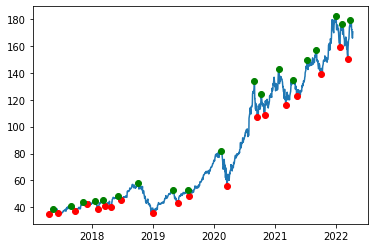

In [12]:
import matplotlib.pyplot as plt

plt.plot(data.Close)
plt.plot(data.minextrema, 'ro')
plt.plot(data.maxextrema, 'go')

/tmp/ipykernel_11837/1123365265.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['minextrema'] = data.iloc[argrelextrema(data.Close.values, np.less_equal,
/tmp/ipykernel_11837/1123365265.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['maxextrema'] = data.iloc[argrelextrema(data.Close.values, np.greater_equal,


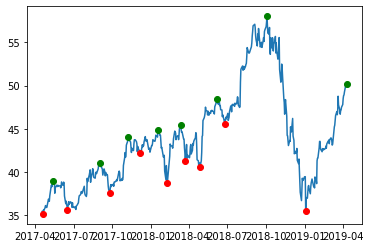

In [13]:
# algorithm: check if new extrema is way higher than before or not
len(data)
subset = data[:500]
subset = setExtrema(subset)
plt.plot(subset.Close)
plt.plot(subset.minextrema, 'ro')
plt.plot(subset.maxextrema, 'go')

In [30]:
maxTimeBetween = 0
maxLast = subset.iloc[0]["Close"]
minTimeBetween = 0
minLast = maxLast
maxTimeAndDifferences = []
minTimeAndDifferences = []

for i in range(len(subset)):
    if not np.isnan(subset.iloc[i]["maxextrema"]):
        maxTimeAndDifferences.append([maxTimeBetween, subset.iloc[i]["Close"] - maxLast])
        maxLast = subset.iloc[i]["Close"]
        maxTimeBetween = 0
    if not np.isnan(subset.iloc[i]["minextrema"]):
        minTimeAndDifferences.append([minTimeBetween, subset.iloc[i]["Close"] - minLast])
        minLast = subset.iloc[i]["Close"]
        minTimeBetween = 0
    maxTimeBetween += 1
    minTimeBetween += 1

maxTimeAndDifferences = pd.DataFrame(maxTimeAndDifferences, columns = ["timeBetween", "diff"])
minTimeAndDifferences = pd.DataFrame(minTimeAndDifferences, columns = ["timeBetween", "diff"])
print(maxTimeAndDifferences.describe())
print(minTimeAndDifferences.describe())



       timeBetween      diff
count     8.000000  8.000000
mean     62.375000  1.837187
std      34.150664  4.807760
min      19.000000 -7.862503
25%      44.250000  0.719998
50%      53.500000  2.517500
75%      79.250000  3.190624
max     129.000000  9.522503
       timeBetween      diff
count     9.000000  9.000000
mean     48.000000  0.010000
std      36.503424  4.593130
min       2.000000 -9.994999
25%      30.000000 -0.654999
50%      41.000000  0.397503
75%      51.000000  2.447502
max     132.000000  4.962498


In [33]:
maxMeanTime = maxTimeAndDifferences.timeBetween.median()
minMeanTime = minTimeAndDifferences.timeBetween.median()
maxMeanDiff = maxTimeAndDifferences["diff"].median()
minMeanDiff = minTimeAndDifferences["diff"].median()

print(f'usually means a maxima occurs every {int(maxMeanTime)} days with a plus of {maxMeanDiff}')
print(f'usually means a minima occurs every {int(minMeanTime)} days with a plus of {minMeanDiff}')

usually means a maxima occurs every 53 days with a plus of 2.5174999237060547
usually means a minima occurs every 41 days with a plus of 0.3975028991699219


In [54]:
from tqdm import tqdm
from ta.momentum import rsi

# but first go back to simple algorithm. if the current day is a max, buy. if current is min, sell (or keep selling)
def tradeLogic(subset):
    subset = setExtrema(subset)
    # get rsi value
    if not np.isnan(subset.iloc[-1]["maxextrema"]):
        # we just reached a maxima
        return 1
    elif not np.isnan(subset.iloc[-1]["minextrema"]):
        # we just reached a low
        return -1
    else:
        return 0

def oneSimulation():
    startMoney = 10000
    money = startMoney
    portfolio = []
    stocks = 0
    lastSignal = 0
    for i in tqdm(range(10,len(data))):
        subset = data.iloc[:i]
        decision = tradeLogic(subset)
        subset["rsi"] = rsi(subset.Close)
        if decision == 0 and lastSignal == -1 and stocks == 0 and money > 10 and subset.rsi[-1] < 40:
            # buy
            amount = money / data.iloc[i]["Close"] * .95
            money -= amount * data.iloc[i]["Close"] * (1 + 0.00025) # comission
            stocks += amount
        elif decision == 0 and lastSignal == 1 and stocks > 0:
            # sell
            money += stocks * data.iloc[i]["Close"] * (1 - 0.00025)
            stocks = 0
        lastSignal = decision
        portfolio.append(money + stocks * data.iloc[i]["Close"])
    # last day sell stocks
    money += stocks * data.iloc[i]["Close"] * (1 - 0.00025)
    stocks = 0
    return money, portfolio

money, portfolio = oneSimulation()
print(money)

  0%|          | 0/259 [00:00<?, ?it/s]/tmp/ipykernel_11837/1123365265.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['minextrema'] = data.iloc[argrelextrema(data.Close.values, np.less_equal,
/tmp/ipykernel_11837/1123365265.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['maxextrema'] = data.iloc[argrelextrema(data.Close.values, np.greater_equal,
/tmp/ipykernel_11837/483558260.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

11081.793870435833


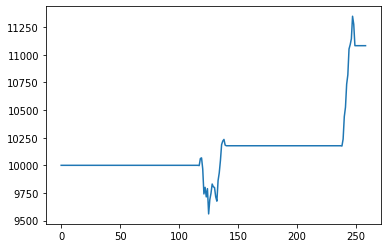

In [55]:
plt.plot(portfolio)